# Diffusers integration with fastai
By Tanishq Abraham

This notebook demonstration a simple-to-use fastai integration with the [HuggingFace Diffusers](https://github.com/huggingface/diffusers/) library.


## Imports

Here are all of our imports. Mostly the fastai library and the Diffusers library.

In [1]:
import diffusers
from fastai.vision.all import *
from fastai.vision.gan import *
from copy import deepcopy

## Data loading

Let's load our data. We'll work with the famous MNIST dataset.

In [2]:
bs = 128 # batch size
size = 32 # image size

In [3]:
path = untar_data(URLs.MNIST)

We use the highly flexible DataBlock API in fastai to create our DataLoaders.

Note that we start with pure noise, generated with the obviously named `generate_noise` function.

In [4]:
dblock = DataBlock(blocks = (TransformBlock, ImageBlock(cls=PILImageBW)),
                   get_x = partial(generate_noise, size=(1, size, size)),
                   get_items = get_image_files,
                   splitter = IndexSplitter(list(range(len(get_image_files(path))))[-bs:]),
                   item_tfms=Resize(size), 
                   batch_tfms = Normalize.from_stats(torch.tensor([0.5]), torch.tensor([0.5])))

In [5]:
dls = dblock.dataloaders(path, path=path, bs=bs)

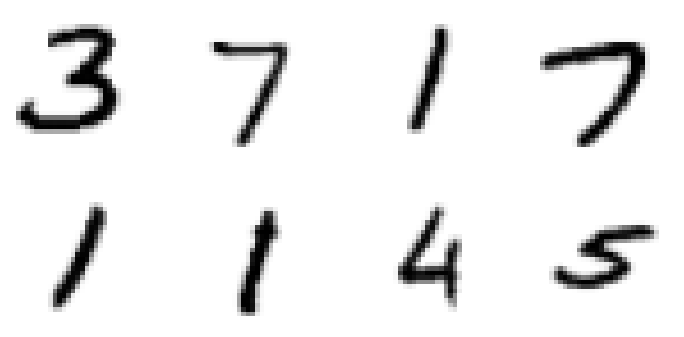

In [6]:
dls.show_batch(max_n=8)

A key aspect of the diffusion models is that our model has the same size input and output:

In [7]:
xb, yb = next(iter(dls.train))
assert xb.shape == yb.shape

## Diffusers Callback

This callback is based on my previous DDPM callback with some additional modifications.


The basic idea is we set a sampler/scheduler which we use to add noise to the image to train our noise-conditioned denoising network. Then during sampling, we create a `Pipeline` which couples our model and scheduler to allow us to sample. We can exchange out different samplers and sampler parameters with the `set_sampler` and `set_sampling_params` functions in the callback.

In [8]:
available_samplers = {
    'DDPM': diffusers.DDPMScheduler,
    'DDIM': diffusers.DDIMScheduler,
    'Karras': diffusers.KarrasVeScheduler,
    'LMS': diffusers.LMSDiscreteScheduler,
    'PNDM': diffusers.PNDMScheduler,
    'VESDE': diffusers.ScoreSdeVeScheduler,
#    'VPSDE': diffusers.ScoreSdeVpScheduler
}

corresponding_pipelines = {
    diffusers.DDPMScheduler: diffusers.DDPMPipeline,
    diffusers.DDIMScheduler: diffusers.DDIMPipeline,
    diffusers.KarrasVeScheduler: diffusers.KarrasVePipeline,
    diffusers.PNDMScheduler: diffusers.PNDMPipeline,
    diffusers.ScoreSdeVeScheduler: diffusers.ScoreSdeVePipeline,

}

In [9]:
class Diffusers(Callback):
    def __init__(self, sampler='DDPM', tensor_type=TensorImage, **kwargs):
        self.tensor_type=tensor_type 
        self.set_sampler(sampler, **kwargs)
    
    def before_batch_training(self):
        eps = self.tensor_type(self.xb[0]) # noise, x_T
        x0 = self.yb[0] # original images, x_0
        batch_size = x0.shape[0]
        t = torch.randint(0, self.sampler.config.num_train_timesteps, (batch_size,), device=x0.device, dtype=torch.long) # select random timesteps
        xt = self.tensor_type(self.sampler.add_noise(x0, eps, t)) # noisify the images
        self.learn.xb = (xt, t) # input to our model is noisy image and timestep
        self.learn.yb = (eps,) # ground truth is the noise 
        
    def before_batch_sampling(self):
        self.pipeline = self.create_pipeline()
        if not hasattr(self, 'sampling_params'): self.set_sampling_params()
        images = self.pipeline(batch_size=self.xb[0].shape[0], output_type="numpy", **self.sampling_params).images
        xt = self.tensor_type(images)
        self.learn.pred = (xt,)
        raise CancelBatchException
        
    def before_batch(self):
        if not hasattr(self, 'gather_preds'): self.before_batch_training()
        else: self.before_batch_sampling()
                 
    def set_sampler(self, sampler_str, **kwargs):
        self.sampler = available_samplers[sampler_str](**kwargs)
        
        
    def create_pipeline(self):
        assert type(self.model) == DiffusersModel, "Need to use DiffusersModel for Pipeline to work"
        return corresponding_pipelines[type(self.sampler)](self.model.m, self.sampler)
    
    
    def set_sampling_params(self, **kwargs):
        self.sampling_params = kwargs

Since Diffusers Pipelines expect models of their own type, we need to use it. But it returns a special dataclass output so we need to get it out and return it directly so fastai knows what to do with it. Hence this `DiffusersModel` class:

In [10]:
class DiffusersModel(nn.Module):
    def __init__(self, **kwargs):
        super().__init__()
        self.m = diffusers.UNet2DModel(**kwargs)
        
    def forward(self, x, t):
        return self.m(x,t).sample

In [11]:
model = DiffusersModel(sample_size=32, in_channels=1, out_channels=1)

Now we can create a Learner as such:

In [12]:
learn = Learner(dls, model, cbs=[Diffusers('DDIM', num_train_timesteps=1000, beta_start=0.0001, beta_end=0.02, tensor_type=TensorImageBW)], loss_func=nn.MSELoss())

And use awesome fastai features like LR finder:

SuggestedLRs(valley=1.737800812406931e-05)

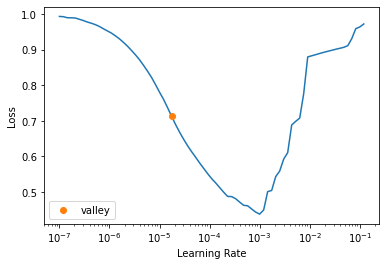

In [13]:
learn.lr_find()

And train with one-cycle LR schedule:

In [14]:
learn.fit_one_cycle(3, 3e-5)

epoch,train_loss,valid_loss,time
0,0.030588,0.042498,03:56
1,0.021469,0.023738,03:55
2,0.020165,0.018912,03:55


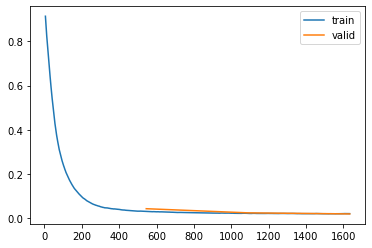

In [15]:
learn.recorder.plot_loss()                      

Let's save our model:

In [16]:
learn.save('diffusers-mnist')

Path('/home/tmabraham/.fastai/data/mnist_png/models/diffusers-mnist.pth')

In [17]:
learn = learn.load('diffusers-mnist')

## Sample generation

Thanks to the fastai API, sample generation is as simple as this:

In [18]:
preds = learn.get_preds()

  0%|          | 0/50 [00:00<?, ?it/s]

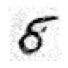

In [27]:
preds[0][4].show()

Awesome, we got a simple MNIST digit!

We can also try out different samplers with different parameters:

In [20]:
learn.diffusers.set_sampler('PNDM', skip_prk_steps=True)

In [21]:
learn.diffusers.set_sampling_params(num_inference_steps=10)

In [22]:
preds = learn.get_preds()

  0%|          | 0/11 [00:00<?, ?it/s]

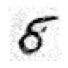

In [28]:
preds[0][4].show()